In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv("datasets/loan_data.csv")

dataset.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

for column in dataset.columns:
    if dataset[column].dtype == "object":
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

X,y = dataset.drop(columns=["loan_status"]), dataset["loan_status"]

X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train, X_test = pd.DataFrame(X_train, columns=X.columns), pd.DataFrame(X_test, columns=X.columns)
y_train, y_test = pd.Series(y_train, name="targets"), pd.Series(y_test, name="targets")

In [4]:
from datagnosis.plugins.generic.plugin_aum import AUMPlugin
from datagnosis.plugins.generic.plugin_conf_agree import ConfAgreePlugin
from datagnosis.plugins.generic.plugin_el2n import EL2NPlugin
from datagnosis.plugins.core.datahandler import DataHandler
from torch.nn import CrossEntropyLoss
import torch

In [5]:
# EL2NPlugin()

class wrapped_model(torch.nn.Module):
    def __init__(self, model, X, y):
        super().__init__()
        self._model=model
        self._model.fit(X, y)
    def forward(self, X):
        return torch.from_numpy(self._model.predict_proba(X)).requires_grad_()
    

skDecisionTree = DecisionTreeClassifier()
skSVC = SVC(probability=True)

decision_tree_model = wrapped_model(skDecisionTree, X_train, y_train)
svc_model = wrapped_model(skSVC, X_train, y_train)

el2plugin_dtree= EL2NPlugin(decision_tree_model, CrossEntropyLoss(), torch.optim.SGD([torch.rand(1).requires_grad_()]), lr=1, epochs=1, num_classes=2)
el2plugin_svc = EL2NPlugin(svc_model, CrossEntropyLoss(), torch.optim.SGD([torch.rand(1).requires_grad_()]), lr=1, epochs=1, num_classes=2)

aumplugin_dtree= AUMPlugin(decision_tree_model, CrossEntropyLoss(), torch.optim.SGD([torch.rand(1).requires_grad_()]), lr=1, epochs=1, num_classes=2)
aumplugin_svc = AUMPlugin(svc_model, CrossEntropyLoss(), torch.optim.SGD([torch.rand(1).requires_grad_()]), lr=1, epochs=1, num_classes=2)

forgettingplugin_dtree= ConfAgreePlugin(decision_tree_model, CrossEntropyLoss(), torch.optim.SGD([torch.rand(1).requires_grad_()]), lr=1, epochs=1, num_classes=2)
forgettingplugin_svc = ConfAgreePlugin(svc_model, CrossEntropyLoss(), torch.optim.SGD([torch.rand(1).requires_grad_()]), lr=1, epochs=1, num_classes=2)

datahandler = DataHandler(X=X_test, y=y_test, batch_size=32)

In [6]:
el2plugin_dtree.fit(datahandler, use_caches_if_exist=False)
el2plugin_svc.fit(datahandler, use_caches_if_exist=False)

aumplugin_dtree.fit(datahandler, use_caches_if_exist=False)
aumplugin_svc.fit(datahandler, use_caches_if_exist=False)

forgettingplugin_dtree.fit(datahandler, use_caches_if_exist=False)
forgettingplugin_svc.fit(datahandler, use_caches_if_exist=False)

In [10]:
print("Error L2 Norm")
print("SVC:",el2plugin_svc.compute_scores())
print("Decision Tree:",el2plugin_dtree.compute_scores())
print()

print("Area Under the Margin")
print("SVC:",aumplugin_svc.compute_scores())
print("Decision Tree:",aumplugin_dtree.compute_scores())
print()

print("Forgetting")
print("SVC:",forgettingplugin_svc.compute_scores())
print("Decision Tree:",forgettingplugin_dtree.compute_scores())

Error L2 Norm
SVC: [0.14504715 0.15180503 0.38238966 ... 0.16238282 0.14559199 0.15680979]
Decision Tree: [0.14465898 0.14465898 0.14465898 ... 0.14465898 0.14465898 0.14465898]

Area Under the Margin
SVC: [0.99816675 0.96687355 0.2522966  ... 0.92008261 0.99560034 0.94441824]
Decision Tree: [1. 1. 1. ... 1. 1. 1.]

Forgetting
SVC: [0.72980286 0.72879343 0.72455922 ... 0.72973941 0.72755013 0.70211699]
Decision Tree: [0.73105858 0.73105858 0.73105858 ... 0.73105858 0.73105858 0.73105858]


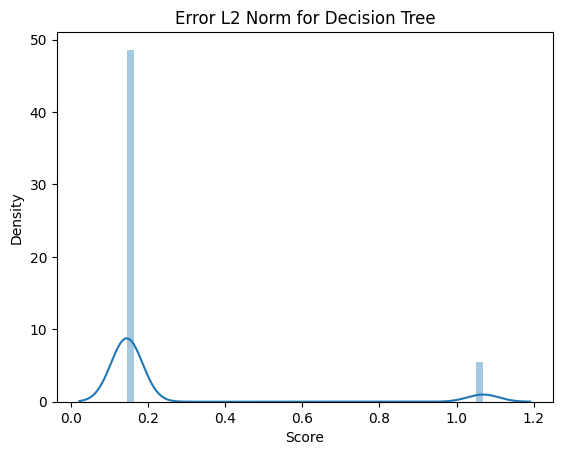

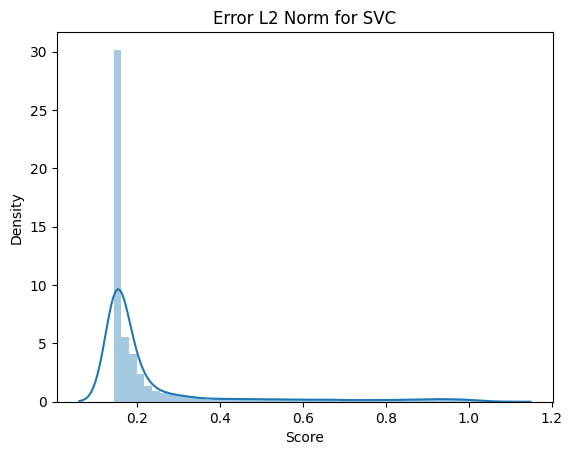

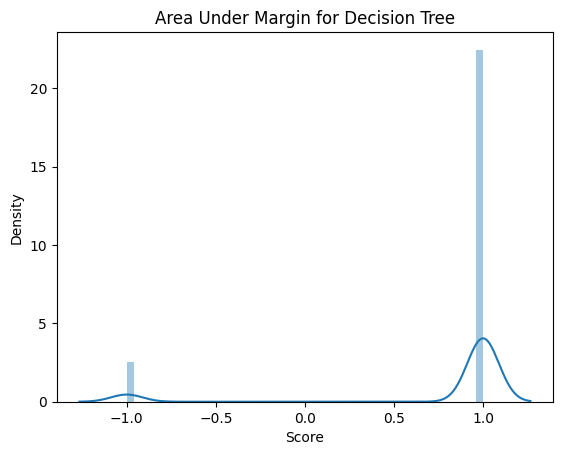

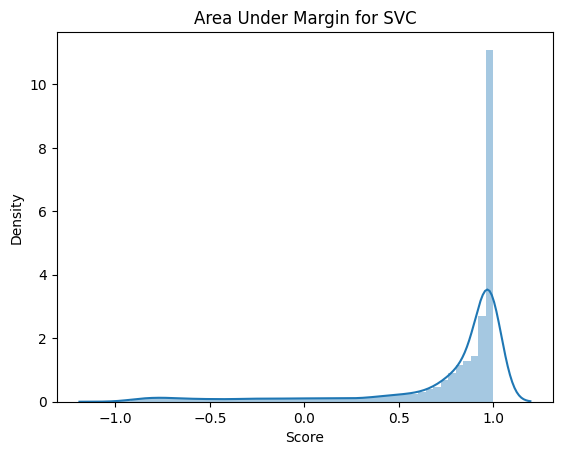

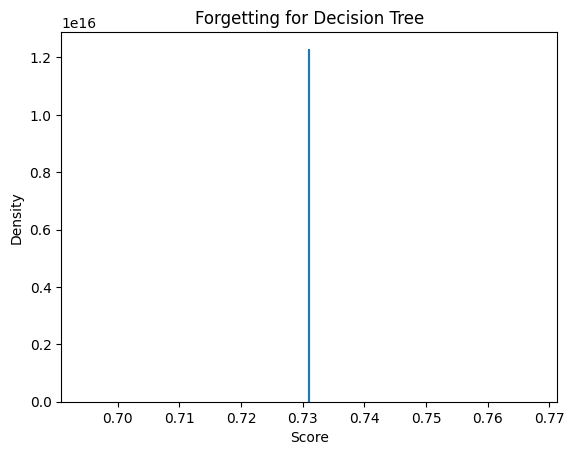

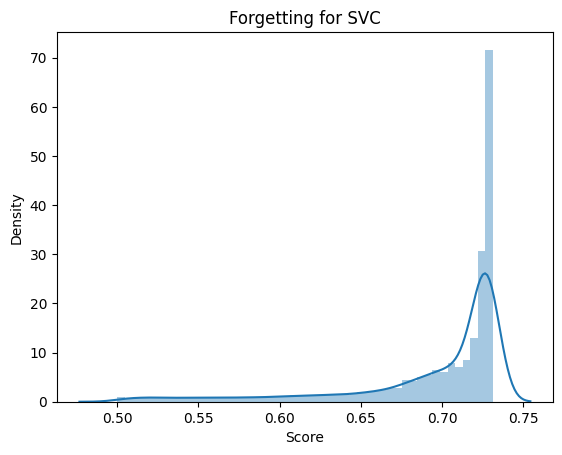

In [13]:
import matplotlib.pyplot as plt

el2plugin_dtree.plot_scores(show=False)
plt.title("Error L2 Norm for Decision Tree")
plt.show()

el2plugin_svc.plot_scores(show=False)
plt.title("Error L2 Norm for SVC")
plt.show()


aumplugin_dtree.plot_scores(show=False)
plt.title("Area Under Margin for Decision Tree")
plt.show()

aumplugin_svc.plot_scores(show=False)
plt.title("Area Under Margin for SVC")
plt.show()


forgettingplugin_dtree.plot_scores(show=False)
plt.title("Forgetting for Decision Tree")
plt.show()

forgettingplugin_svc.plot_scores(show=False)
plt.title("Forgetting for SVC")
plt.show()

<p>To identify top-10 hardest examples lets use the Error-L2 Norm metric</p>

In [17]:
svc_hardest = el2plugin_svc.compute_scores().argsort()[::-1][:10]
dtree_hardest = el2plugin_dtree.compute_scores().argsort()[::-1][:10]

print("svc hardest:")
for row in svc_hardest:
    print(X_test.iloc[row], end="\n\n")
print("\n========================================================================\n")
print("decision tree hardest:")
for row in dtree_hardest:
    print(X_test.iloc[row], end="\n\n")

svc hardest:
person_age                        0.535285
person_gender                    -1.110069
person_education                 -0.502953
person_income                    -0.240210
person_emp_exp                    0.427094
person_home_ownership             0.904822
loan_amnt                        -0.440735
loan_intent                      -0.882904
loan_int_rate                     2.780805
loan_percent_income              -0.340837
cb_person_cred_hist_length        0.549665
credit_score                     -0.745683
previous_loan_defaults_on_file   -1.016040
Name: 22201, dtype: float64

person_age                        0.204436
person_gender                    -1.110069
person_education                 -0.502953
person_income                     0.390131
person_emp_exp                    0.097249
person_home_ownership            -1.177817
loan_amnt                         2.441376
loan_intent                      -0.882904
loan_int_rate                     2.824448
loan_percent